In [1]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
## Load dataset

IMG_SHAPE = (96, 96, 3)
original_data = pd.read_csv("updated_train.csv")

In [3]:
threshold = 30
data = original_data.dropna(thresh = threshold)
features_to_estimate = data.shape[1]-1
print(features_to_estimate)

30


Inspection of the dataset.

In [4]:
print("Dimensions of the dataset: ", data.shape)
print(data.loc[1,:])

Dimensions of the dataset:  (2180, 31)
left_eye_center_x                                                      64.3329
left_eye_center_y                                                      34.9701
right_eye_center_x                                                     29.9493
right_eye_center_y                                                     33.4487
left_eye_inner_corner_x                                                58.8562
left_eye_inner_corner_y                                                35.2743
left_eye_outer_corner_x                                                70.7227
left_eye_outer_corner_y                                                36.1872
right_eye_inner_corner_x                                               36.0347
right_eye_inner_corner_y                                               34.3615
right_eye_outer_corner_x                                               24.4725
right_eye_outer_corner_y                                               33.1444
left_eyebrow_

Let's find if there are missing values 

In [5]:
data.isnull().sum()/data.shape[0]

left_eye_center_x            0.0
left_eye_center_y            0.0
right_eye_center_x           0.0
right_eye_center_y           0.0
left_eye_inner_corner_x      0.0
left_eye_inner_corner_y      0.0
left_eye_outer_corner_x      0.0
left_eye_outer_corner_y      0.0
right_eye_inner_corner_x     0.0
right_eye_inner_corner_y     0.0
right_eye_outer_corner_x     0.0
right_eye_outer_corner_y     0.0
left_eyebrow_inner_end_x     0.0
left_eyebrow_inner_end_y     0.0
left_eyebrow_outer_end_x     0.0
left_eyebrow_outer_end_y     0.0
right_eyebrow_inner_end_x    0.0
right_eyebrow_inner_end_y    0.0
right_eyebrow_outer_end_x    0.0
right_eyebrow_outer_end_y    0.0
nose_tip_x                   0.0
nose_tip_y                   0.0
mouth_left_corner_x          0.0
mouth_left_corner_y          0.0
mouth_right_corner_x         0.0
mouth_right_corner_y         0.0
mouth_center_top_lip_x       0.0
mouth_center_top_lip_y       0.0
mouth_center_bottom_lip_x    0.0
mouth_center_bottom_lip_y    0.0
Image     

## Prepare the dataset

In [6]:
from sklearn.model_selection import train_test_split

Y = data.iloc[:, :-1]
X_raw = data.iloc[:,-1]
dim_output = len(Y.columns.values)
original_batch_size = len(X_raw)
print(X_raw.shape, Y.shape)

(2180,) (2180, 30)


In [7]:
def convert_X(Xdf):
    """
    Function to convert each "Image" field in the csv file into a (96, 96, 1) image. 
    """
    batch_size = len(Xdf)
    X = np.zeros((batch_size, 96, 96, 3))

    for row in range(batch_size):
        for idx in range(3):
            X[row, :,:, idx] = np.array([float(i) for i in Xdf.iloc[row].split(" ")]).reshape(1,96,96)/255
    return X


X = convert_X(X_raw)
print(X.shape)
# XX_shape = list(XX.shape)
# XX_shape[-1] = 3
# X = np.zeros(XX_shape)
# for i in range(3):
#     X[:,:,:,i] = XX[:,:,:,0]

(2180, 96, 96, 3)


In [8]:
# Split train, validation and test set

XXtrain, Xtest, YYtrain, Ytest = train_test_split(X, Y, test_size = 0.05)
Xtrain, Xval, Ytrain, Yval = train_test_split(XXtrain, YYtrain, test_size = 0.2)

print("Train set: ", Xtrain.shape, Ytrain.shape)
print("Validation set: ", Xval.shape, Yval.shape)
print("Test set: ", Xtest.shape, Ytest.shape)

Train set:  (1656, 96, 96, 3) (1656, 30)
Validation set:  (415, 96, 96, 3) (415, 30)
Test set:  (109, 96, 96, 3) (109, 30)


In [9]:
print(Ytrain)

      left_eye_center_x  left_eye_center_y  right_eye_center_x  \
571           64.614307          36.359895           29.853197   
1512          66.316027          39.707919           31.209342   
2327          65.681818          37.785714           27.500000   
1921          65.281857          35.016512           30.906550   
295           66.605268          38.765268           29.632000   
223           62.945143          36.002400           31.686857   
47            66.824949          40.912271           31.557153   
1691          65.815203          34.739132           29.556499   
921           67.740939          40.153795           29.688209   
213           65.065987          37.575134           30.633783   
1527          68.096000          36.216000           28.215636   
202           65.589029          37.254857           27.793371   
2080          59.254810          32.655394           30.538776   
1357          67.517205          34.911036           29.865542   
11        

## Apply transfer learning with pre-trained CNN
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=it

In [10]:
import tensorflow as tf
keras = tf.keras
# Specify include_top=False not to include the last layer
base_model = keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                           include_top = False,
                                           weights = "imagenet")

In [11]:
# Set the base model not to be trainable
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [12]:
ex_features = base_model(Xtrain[:4,:,:,:])
print(ex_features.shape)

W1219 18:57:25.745433 25808 base_layer.py:1814] Layer Conv1_pad is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(4, 3, 3, 1280)


We can see that the loaded CNN returns a (3,3,1280) tensor for each example. We need an output with shape (30,1). To this aim, let's follow the tutorial and add a [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.

The `GlobalAveragePooling2D` layer is used to average each channel and reduce the final dimensions to (batch_size, 1, 1, 1280). 

The `Dense` layer is used to reduce the number of outputs from 1280 to 30. Since we need a coordinate between 0 and 96, we can use a linear activation.

In [13]:
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(features_to_estimate)

In [14]:
model = tf.keras.Sequential([base_model,
                             global_average_pooling_layer,
                             dense_layer])

Compile the model. We will use an Adam optimiser and the MSE as loss function. Since the competition evaulates the results with the root MSE, we will define a new metric for that.

In [15]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="mse", metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                38430     
Total params: 2,296,414
Trainable params: 38,430
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
len(model.trainable_variables)

2

Let's fit the model

In [18]:
history = model.fit(x=np.array(Xtrain),
    y=np.array(Ytrain),    
    epochs=50,
    verbose=1,
    initial_epoch=0,
    validation_data=(np.array(Xval), np.array(Yval)),
    shuffle=True)

Train on 1656 samples, validate on 415 samples
Epoch 1/50
1656/1656 [==============================] - 4s 3ms/sample - loss: 2517.0876 - root_mean_squared_error: 50.1706 - val_loss: 2393.3802 - val_root_mean_squared_error: 48.9222
Epoch 2/50
1656/1656 [==============================] - 1s 481us/sample - loss: 2286.4201 - root_mean_squared_error: 47.8165 - val_loss: 2171.7794 - val_root_mean_squared_error: 46.6024
Epoch 3/50
1656/1656 [==============================] - 1s 491us/sample - loss: 2074.8889 - root_mean_squared_error: 45.5509 - val_loss: 1968.8532 - val_root_mean_squared_error: 44.3718
Epoch 4/50
1656/1656 [==============================] - 1s 481us/sample - loss: 1882.5241 - root_mean_squared_error: 43.3881 - val_loss: 1783.5231 - val_root_mean_squared_error: 42.2318
Epoch 5/50
1656/1656 [==============================] - 1s 481us/sample - loss: 1704.9033 - root_mean_squared_error: 41.2905 - val_loss: 1614.3268 - val_root_mean_squared_error: 40.1787
Epoch 6/50
1656/1656 [===

1656/1656 [==============================] - 1s 485us/sample - loss: 69.4711 - root_mean_squared_error: 8.3349 - val_loss: 65.3123 - val_root_mean_squared_error: 8.0816
Epoch 46/50
1656/1656 [==============================] - 1s 486us/sample - loss: 70.2600 - root_mean_squared_error: 8.3821 - val_loss: 64.1450 - val_root_mean_squared_error: 8.0091
Epoch 47/50
1656/1656 [==============================] - 1s 504us/sample - loss: 67.7480 - root_mean_squared_error: 8.2309 - val_loss: 63.1879 - val_root_mean_squared_error: 7.9491
Epoch 48/50
1656/1656 [==============================] - 1s 487us/sample - loss: 66.2524 - root_mean_squared_error: 8.1396 - val_loss: 62.3931 - val_root_mean_squared_error: 7.8989
Epoch 49/50
1656/1656 [==============================] - 1s 492us/sample - loss: 66.6273 - root_mean_squared_error: 8.1626 - val_loss: 61.7324 - val_root_mean_squared_error: 7.8570
Epoch 50/50
1656/1656 [==============================] - 1s 488us/sample - loss: 63.8498 - root_mean_square

In [ ]:
history = model.fit(x=np.array(Xtrain),
    y=np.array(Ytrain),    
    epochs=100,
    verbose=1,
    initial_epoch=50,
    validation_data=(np.array(Xval), np.array(Yval)),
    shuffle=True)

<IPython.core.display.Javascript object>


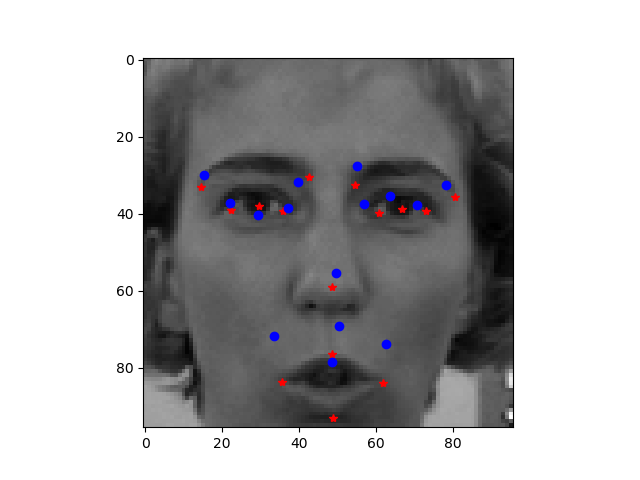

In [19]:
idx = 4
XXX = np.array(Xtrain)
YYY = np.array(Ytrain)
prediction = model.predict(XXX)
plt.imshow(XXX[idx,:,:,0], cmap = "gray")
plt.plot(YYY[idx,::2], YYY[idx, 1::2], "*r")
plt.plot(prediction[idx,::2], prediction[idx,1::2], "ob")